# Plot the streamlines for LLC4320 surface flow

We will be using just one level (the surface) of a single snapshot in time to make it faster.
This will create a particle moving in 2D at the surface.
The trajectories are pre-computed by `compute_LLC4320_particle_trajectories.ipynb` then plotted in this notebook.

Setup and import packages 

In [1]:
import xarray as xr
import matplotlib.pyplot as plt 
import cmocean
import cartopy.crs as ccrs
import numpy as np
from pathlib import Path
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

## Load Data
If the particle trajectory location and speed data is already pre-computed, then just load it (otherwise, run `compute_LLC4320_particle_trajectories.ipynb`). 
Also, check for the topography data and download if necessary.

In [2]:
path_to_file_lats = 'LLC4320lats.npy'
path_lats = Path(path_to_file_lats)
path_to_file_lons = 'LLC4320lons.npy'
path_lons = Path(path_to_file_lons)
path_to_file_spds = 'LLC4320spds.npy'
path_spds = Path(path_to_file_spds)

if path_lats.is_file() & path_lons.is_file() & path_spds.is_file():
    print(f'The files {path_to_file_lats} and {path_to_file_lons} and {path_to_file_spds} exist...reading...')
    lons = np.load('LLC4320lons.npy')
    lats = np.load('LLC4320lats.npy')
    spds = np.load('LLC4320spds.npy')
else:
    print(f'The file {path_to_file_lats} or {path_to_file_lons} or {path_to_file_spds} does not exist.\n Run `compute_LLC4320_particle_trajectories.ipynb` to create them.\n\n')
    exit()

# Download the topography data if you don't already have it.
path_to_file_topo = 'ETOPO1_Ice_g_gmt4.grd'
path_topo = Path(path_to_file_topo)
if not(path_topo.is_file()):
    print(f'The file {path_to_file_topo} does not exist...downloading...')
    !wget https://www.ngdc.noaa.gov/mgg/global/relief/ETOPO1/data/ice_surface/grid_registered/netcdf/ETOPO1_Ice_g_gmt4.grd.gz 
    !gunzip ETOPO1_Ice_g_gmt4.grd.gz
else:
    print(f'The file {path_to_file_topo} exists...reading...')
    
grid = xr.open_dataset('ETOPO1_Ice_g_gmt4.grd', decode_cf=True, engine='netcdf4')
grid=grid.where(grid.z>0)      # We throw away the underwater part of the topography. 

The files LLC4320lats.npy and LLC4320lons.npy and LLC4320spds.npy exist...reading...
The file ETOPO1_Ice_g_gmt4.grd exists...reading...


To speed up the computation, we transform the lat lon outside the plotting for-loop. 

### Define plotting function

In [3]:
def plot_hemisphere(traj_data,spds,grid,ymins):
    
    xx = traj_data[:,:,0]
    yy = traj_data[:,:,1]
    # bins = 4      # Production plot
    bins = 64     # Quick plot for testing

    for i in range(0,lons.shape[1],bins):
        if i%512==0:
            print(i,end = ' ')
        y = yy.T[i][1:]
        x = xx.T[i][1:]
        if np.max(x)-np.min(x)>300:
            x[x<0]+=360
        dydx = (0.5 * (spds.T[i][:-1] + spds.T[i][1:]))[1:]  # first derivative

    # Create a set of line segments so that we can color them individually
    # This creates the points as a N x 1 x 2 array so that we can stack points
    # together easily to get the segments. The segments array for line collection
    # needs to be (numlines) x (points per line) x 2 (for x and y)
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Create a continuous norm to map from data points to colors
        norm = plt.Normalize(0, 1.)
        lc = LineCollection(segments, cmap='GnBu_r', norm=norm)
    
    # Set the values used for colormapping
        lc.set_array(dydx)
        lc.set_linewidth(0.3)
        line = axs.add_collection(lc)
    print('finished plotting lines (lazily)')
    axs.pcolormesh(grid.x[::bins], 
                   grid.y[::bins], 
                   grid.z[::bins,::bins], 
                   transform=ccrs.PlateCarree(), 
                   cmap='bone',vmin= -3000,vmax = 4500,
                   zorder = 20
               )
    print('finished making the map')

# Tidy up
    axs.set_facecolor('lightsteelblue')
    axs.set_extent([-1e4, 1e4, ymins[0], ymins[1]], crs=ccrs.PlateCarree())
    plt.tight_layout()

### Northern hemisphere

0 512 finished plotting lines (lazily)
finished making the map
CPU times: user 27 s, sys: 0 ns, total: 27 s
Wall time: 26.6 s


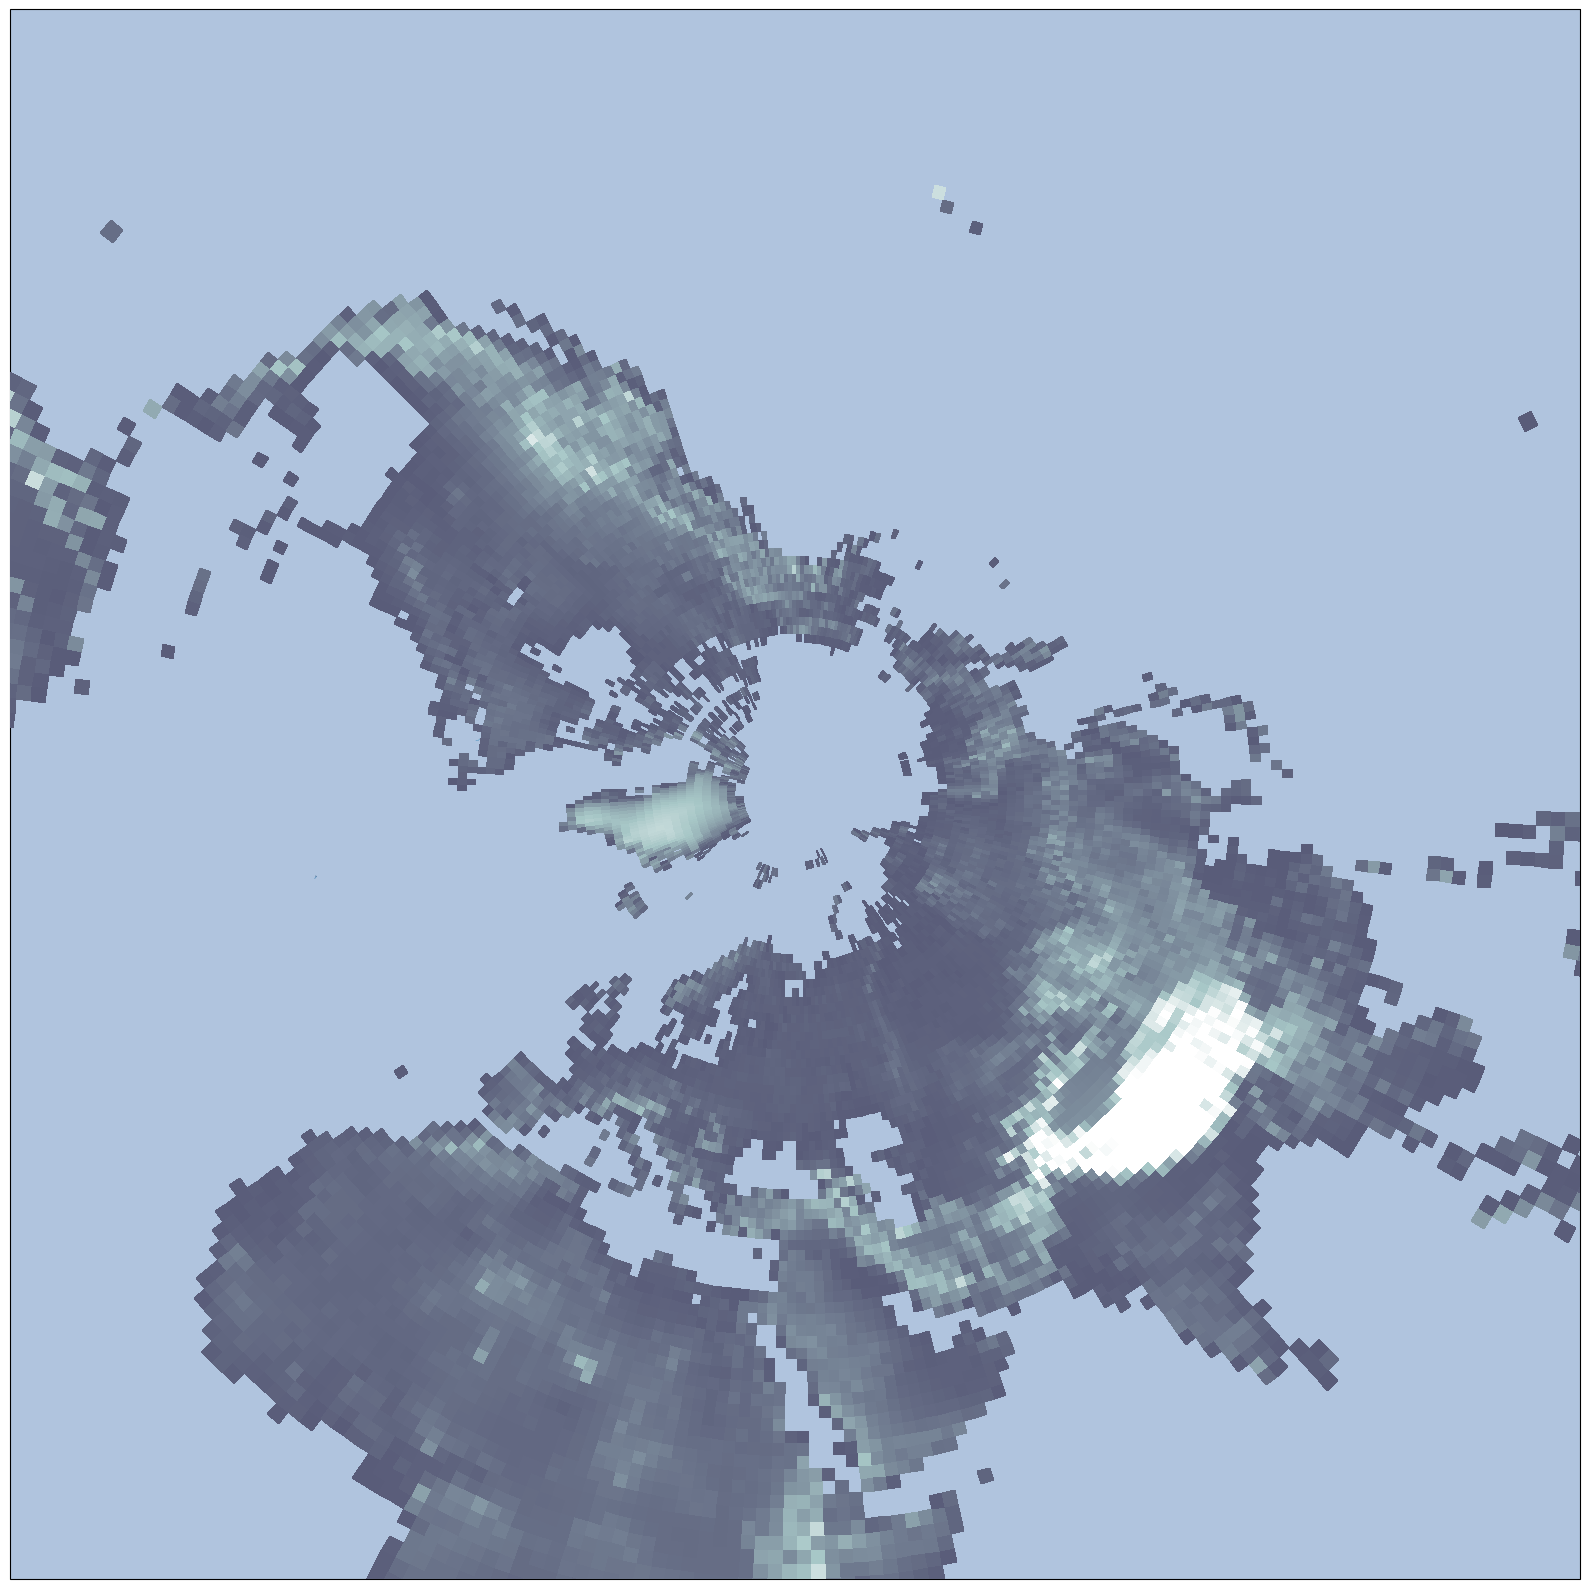

In [4]:
%%time
proj = ccrs.NorthPolarStereo(central_longitude=38.0)
traj_data = proj.transform_points(ccrs.PlateCarree(),lons,lats)
fig = plt.figure(figsize=(16, 16))
axs = fig.add_subplot(1, 1, 1, projection=ccrs.NorthPolarStereo(central_longitude=38.0))    
ymins = np.array([6.5, 1000])
plot_hemisphere(traj_data,spds,grid,ymins)
plt.savefig('NorthernHemisphere.pdf')

### Southern hemisphere

0 512 finished plotting lines (lazily)
finished making the map
CPU times: user 25.2 s, sys: 0 ns, total: 25.2 s
Wall time: 25.1 s


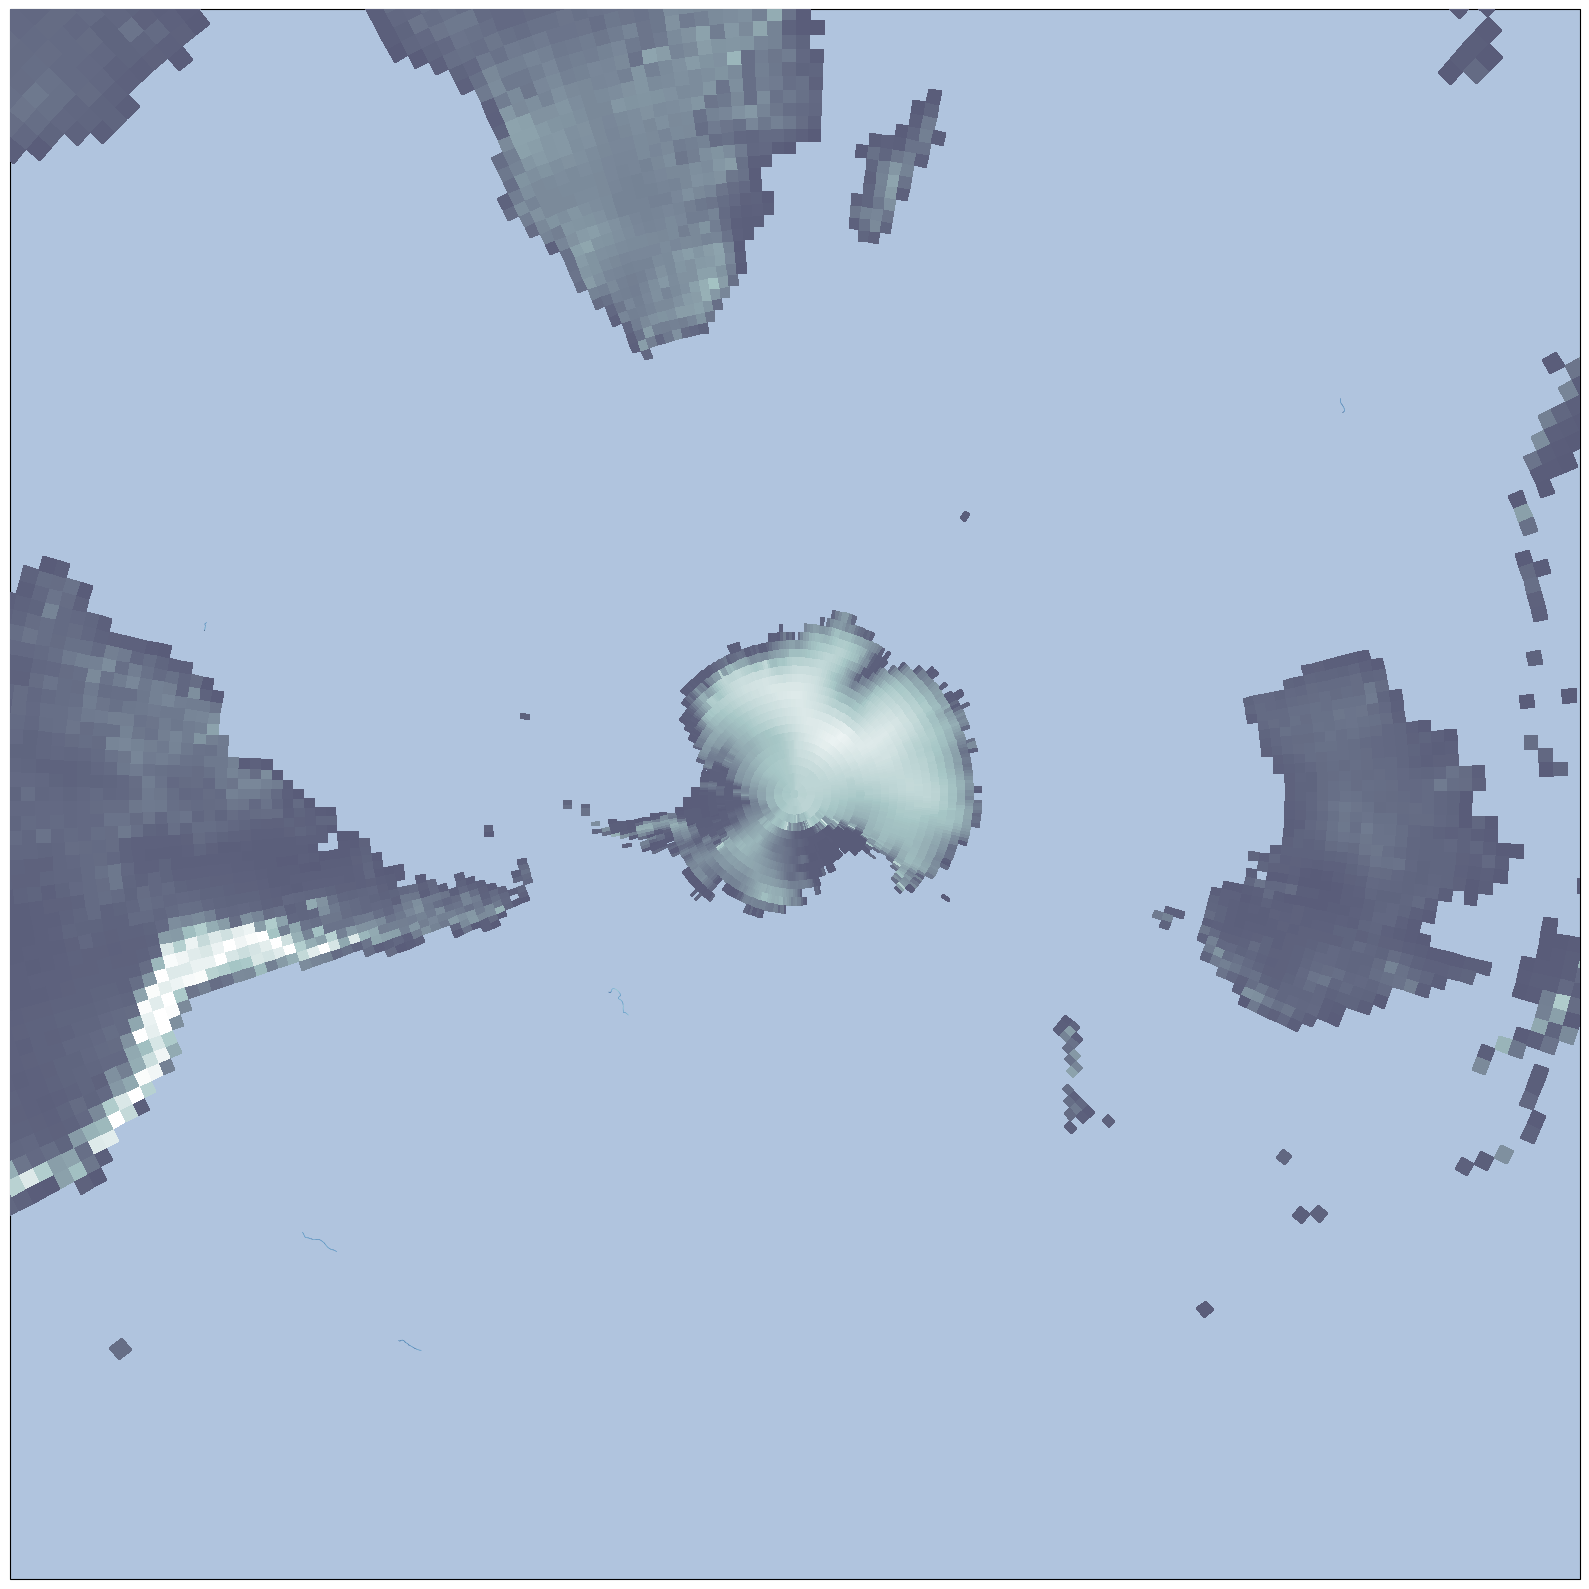

In [5]:
%%time
proj = ccrs.SouthPolarStereo(central_longitude=38.0)
traj_data = proj.transform_points(ccrs.PlateCarree(),lons,lats)
fig = plt.figure(figsize=(16, 16))
axs = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo(central_longitude=38.0))
ymins = np.array([-1000, -6.5])
plot_hemisphere(traj_data,spds,grid,ymins)
plt.savefig('SouthernHemisphere.pdf')